In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from dask.distributed import Client
import scipy

### Working with AUS2200 data on model levels

Convert hybrid height coordinate to height above the surface, and interpolate to regular height intervals

In [2]:
#From ~access/umdir/vn13.8/ctldata/vert/vertlevs_L70_50t_20s_80km

#This is a list of AUS2200 model levels and associated metadata, that will be used to reconstruct the hybrid height coordinate

z_top_of_model = 40000.00
first_constant_r_rho_level= 62
eta_theta=np.array([0.0000000E+00,   0.1250000E-03,   0.5416666E-03,   0.1125000E-02,   0.1875000E-02,
0.2791667E-02,   0.3875000E-02,   0.5125000E-02,   0.6541667E-02,   0.8125000E-02,
0.9875000E-02,   0.1179167E-01,   0.1387500E-01,   0.1612500E-01,   0.1854167E-01,
0.2112500E-01,   0.2387500E-01,   0.2679167E-01,   0.2987500E-01,   0.3312500E-01,
0.3654167E-01,   0.4012500E-01,   0.4387500E-01,   0.4779167E-01,   0.5187500E-01,
0.5612501E-01,   0.6054167E-01,   0.6512500E-01,   0.6987500E-01,   0.7479167E-01,
0.7987500E-01,   0.8512500E-01,   0.9054167E-01,   0.9612500E-01,   0.1018750E+00,
0.1077917E+00,   0.1138750E+00,   0.1201250E+00,   0.1265417E+00,   0.1331250E+00,
0.1398750E+00,   0.1467917E+00,   0.1538752E+00,   0.1611287E+00,   0.1685623E+00,
0.1761954E+00,   0.1840590E+00,   0.1921980E+00,   0.2006732E+00,   0.2095645E+00,
0.2189729E+00,   0.2290236E+00,   0.2398690E+00,   0.2516917E+00,   0.2647077E+00,
0.2791699E+00,   0.2953717E+00,   0.3136506E+00,   0.3343919E+00,   0.3580330E+00,
0.3850676E+00,   0.4160496E+00,   0.4515977E+00,   0.4924007E+00,   0.5392213E+00,
0.5929016E+00,   0.6543679E+00,   0.7246365E+00,   0.8048183E+00,   0.8961251E+00,
0.1000000E+01])
eta_rho=np.array([0.6249999E-04,   0.3333333E-03,   0.8333333E-03,   0.1500000E-02,   0.2333333E-02,
0.3333333E-02,   0.4500000E-02,   0.5833333E-02,   0.7333333E-02,   0.9000000E-02,
0.1083333E-01,   0.1283333E-01,   0.1500000E-01,   0.1733333E-01,   0.1983333E-01,
0.2250000E-01,   0.2533333E-01,   0.2833333E-01,   0.3150000E-01,   0.3483333E-01,
0.3833333E-01,   0.4200000E-01,   0.4583333E-01,   0.4983333E-01,   0.5400000E-01,
0.5833334E-01,   0.6283334E-01,   0.6750000E-01,   0.7233334E-01,   0.7733333E-01,
0.8250000E-01,   0.8783333E-01,   0.9333333E-01,   0.9900000E-01,   0.1048333E+00,
0.1108333E+00,   0.1170000E+00,   0.1233333E+00,   0.1298333E+00,   0.1365000E+00,
0.1433333E+00,   0.1503334E+00,   0.1575020E+00,   0.1648455E+00,   0.1723789E+00,
0.1801272E+00,   0.1881285E+00,   0.1964356E+00,   0.2051189E+00,   0.2142687E+00,
0.2239982E+00,   0.2344463E+00,   0.2457803E+00,   0.2581997E+00,   0.2719388E+00,
0.2872708E+00,   0.3045112E+00,   0.3240212E+00,   0.3462124E+00,   0.3715503E+00,
0.4005586E+00,   0.4338236E+00,   0.4719992E+00,   0.5158110E+00,   0.5660614E+00,
0.6236348E+00,   0.6895022E+00,   0.7647274E+00,   0.8504717E+00,   0.9480625E+00])

### First check what the `lev` dimension actually represents


`atmosphere_hybrid_height_coordinate` is defined by:
`Z(i, j, k) = Zsea(k) + C(k) * orography(i, j)`

Where `Zsea` is 

`Zsea(k) = eta(k) * top_level_height`

And `C` is

`C(k) = (1 - eta(k) / eta(first_constant_r_rho_level))**2` for `k <= first_constant_r_rho_level`

and

`C(k) = 0` for `k > first_constant_r_rho_level`

(from http://climate-cms.wikis.unsw.edu.au/Vertical_Coordinates)

In [3]:
#Calculate Zsea from the above equation using the actual model levels (rho levels here for wind data)
Zsea = (eta_rho * z_top_of_model)

#Load the atmosphere_hybrid_height_coordinate variable as levs
ua = xr.open_dataset(
    "/g/data/bs94/AUS2200/mjo-neutral2013/v1-0/1hr/ua/ua_AUS2200_mjo-neutral_1hrPt_201303011900-201303020000.nc",
    chunks={}
    )
levs = ua.lev.values

In [4]:
#Compare the two
Zsea[0:66] == levs

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

### So the levs dimension represents Zsea. 

Now we can use this to calculate the actual height coordinate, `Z`, but we first need to load orography and calculate `C`

In [5]:
#Load orography
orog = xr.open_dataset("/g/data/bs94/AUS2200/mjo-neutral2013/v1-0/fx/orog/orog_AUS2200_mjo-neutral_fx.nc")

In [6]:
#Calculate C from the model rho levels
C = (1 - eta_rho / eta_rho[first_constant_r_rho_level-1])**2
C[first_constant_r_rho_level:] = 0

In [7]:
#Z will be of shape lat,lon,lev, so repeat C over lat/lon dimensions
C_repeated = np.repeat(
        np.repeat(
        C[np.newaxis,np.newaxis,0:len(levs)],
        orog.orog.shape[0],
        axis=0),
    orog.orog.shape[1],
    axis=1
)

In [8]:
#And repeat orography over the level dimension
orog_repeated = np.repeat(
    orog.orog.values[:,:,np.newaxis],
    len(levs),
    axis=2)

In [9]:
#Calculate Z
Z = levs + C_repeated * orog_repeated

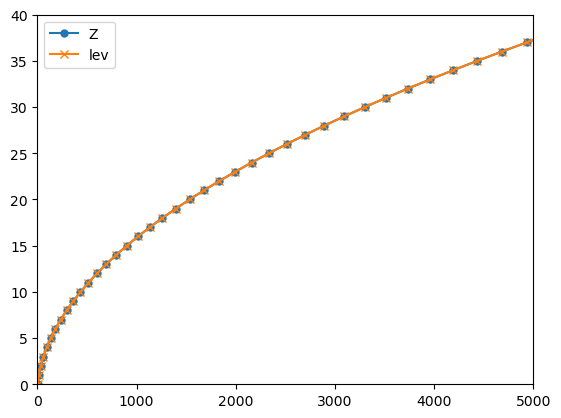

In [10]:
#Compare Z and levs for a point the ocean. They should be the same

plt.plot(Z[0,0,:],np.arange(66),marker="o",ms=5,label="Z")
plt.ylim([0,40])
plt.xlim([0,5000])

plt.plot(levs,np.arange(66),marker="x",label="lev")

plt.legend()

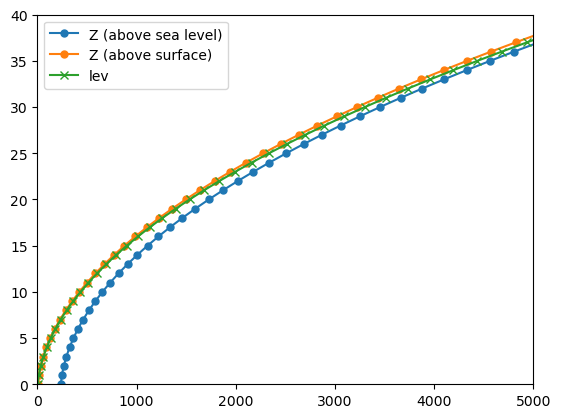

In [11]:
#Compare Z and levs over the land (for a point 233 m above sea level).
plt.plot(Z[1000,1000,:],np.arange(66),marker="o",ms=5,label="Z (above sea level)")
plt.ylim([0,40])
plt.xlim([0,5000])

plt.plot(Z[1000,1000,:] - orog_repeated[1000,1000,:],np.arange(66),marker="o",ms=5,label="Z (above surface)")
plt.ylim([0,40])
plt.xlim([0,5000])

plt.plot(levs,np.arange(66),marker="x",label="lev")

plt.legend()

Text(0, 0.5, 'Zsea')

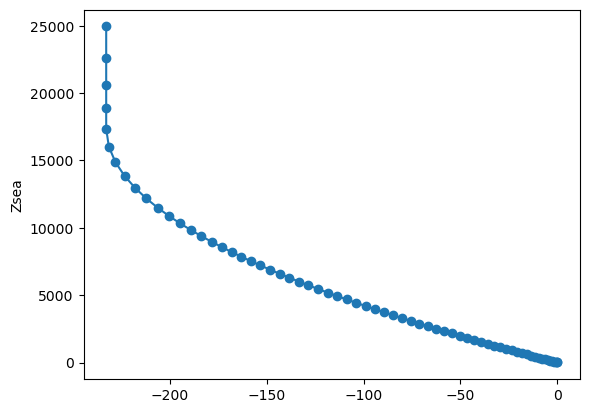

In [20]:
#Plot the difference between Z and lev. Difference increases with altitude as the hybrid-height coordinates transition
# from closely following the terrain to being more uniform across the grid
plt.plot(
    (Z[1000,1000,:] - orog_repeated[1000,1000,:]) - levs,
    levs,marker="o")
plt.ylabel("Zsea")

In [12]:
def interp_scipy(x, xp, fp):
    f = scipy.interpolate.interp1d(xp, fp, kind="linear", fill_value="extrapolate")
    return f(x)

def interp_model_level_to_z(z_da,var_da,mdl_dim,heights):

    '''
    Linearly interpolate from model level data to height levels.
    If the requested height is below the lowest model level, data from the lowest model level is returned.
    If the requested height is above the highest model level, then NaNs are returned.

    Input
    z_da: xarray Dataarray of height
    var_da: xarray Dataarray of variable to interpolate
    mdl_dim: name of the model level dimension (e.g. hybrid). NOTE that model levels must be decreasing (so height is increasing)
    heights: numpy array of height levels
    '''

    #assert z_da[mdl_dim][0] > z_da[mdl_dim][-1], "Model levels should be decreasing"

    interp_da = xr.apply_ufunc(interp_scipy,
                heights,
                z_da,
                var_da,
                input_core_dims=[ ["height"], [mdl_dim], [mdl_dim]],
                output_core_dims=[["height"]],
                exclude_dims=set((mdl_dim,)),
                dask="parallelized",
                output_dtypes=[var_da.dtype],
                vectorize=True)
    interp_da["height"] = heights
    
    return interp_da

In [13]:
client = Client()
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33785 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/33785/status,
Dashboard: /proxy/33785/status,Workers: 7
Total threads: 7,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33137,Workers: 7
Dashboard: /proxy/33785/status,Total threads: 7
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:39893,Total threads: 1
Dashboard: /proxy/46853/status,Memory: 4.57 GiB
Nanny: tcp://127.0.0.1:41131,


In [14]:
#Convert the height array to a chunked xarray dataarray
Z_agl_da = xr.DataArray(Z - orog_repeated,
             dims=["lat","lon","lev"],
            coords={"lat":ua.lat,"lon":ua.lon,"lev":ua.lev}).chunk({
    "lev":-1,
    "lon":ua.ua.chunksizes["lon"][0],
    "lat":ua.ua.chunksizes["lat"][0]})

In [15]:
#Interpolate the U wind onto regular heights at 100 m intervals up to 4500 m
ua_interp = interp_model_level_to_z(
    Z_agl_da,
    ua.isel(time=0).ua.chunk({"lev":-1}),
    "lev",
    np.arange(0,4600,100)
)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 2.71 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


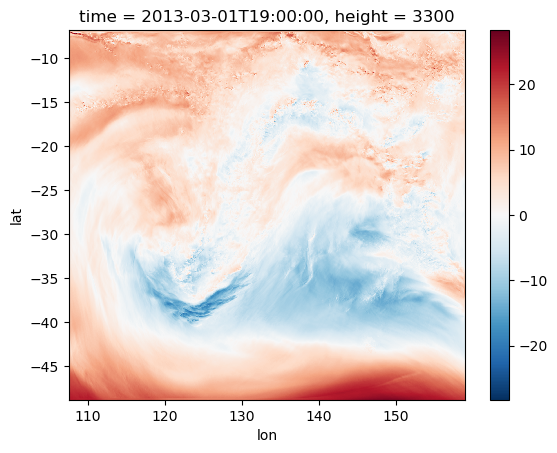

In [16]:
#Plot the interpolated winds

ua_interp.sel(height=3300).plot()

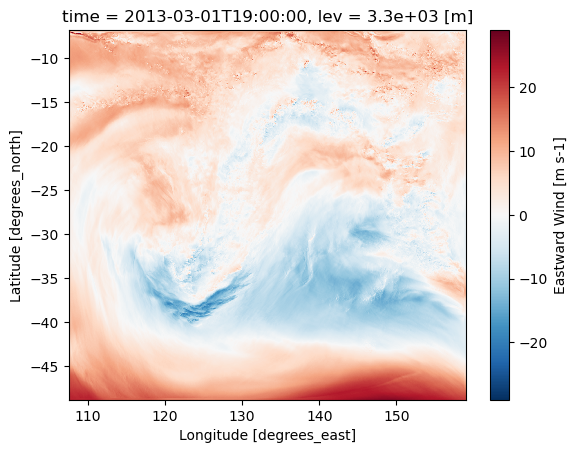

In [17]:
#Compared with the original data 

ua.isel(lev=30,time=0).ua.plot()

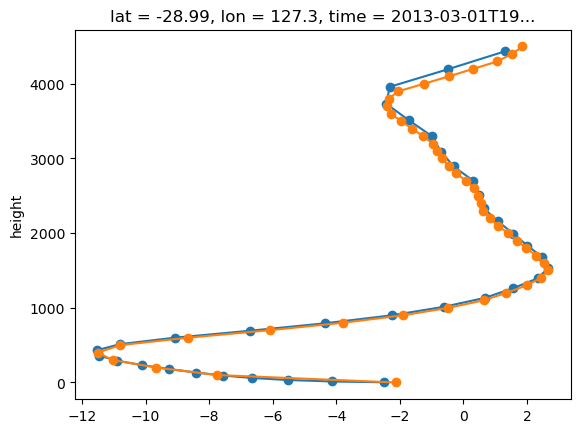

In [21]:
#Compare vertical profiles for a point over the land

ua.isel(time=0,lat=1000,lon=1000).sel(lev=slice(0,4500)).ua.plot(y="lev",marker="o")
ua_interp.isel(lat=1000,lon=1000).plot(y="height",marker="o")

In [27]:
xr.Dataset({"Z_agl":Z_agl_da.assign_attrs(
    {"description":"Height above surface for the AUS2200 grid",
    "units":"m"}
     )}).to_zarr("/g/data/ng72/ab4502/sea_breeze_detection/aus2200_z_agl.zarr")

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 2.71 GiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
